## 0. Device selection

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Data preprocessing

In [2]:
from functools import lru_cache

import numpy as np
import torch
from tensorflow.keras import preprocessing
from tensorflow.keras.datasets import imdb
from torch.utils.data import DataLoader


@lru_cache
def _download_data(
    vocab_size: int | None
) -> tuple[tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]]:
    """Loads the IMDB dataset.

    docs (https://keras.io/api/datasets/imdb/):
    This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment
    (positive/negative). Reviews have been preprocessed, and each review is encoded as
    a list of word indexes (integers). For convenience, words are indexed by overall
    frequency in the dataset, so that for instance the integer "3" encodes the 3rd most
    frequent word in the data. This allows for quick filtering operations such as: "only
    consider the top 10,000 most common words, but eliminate the top 20 most common
    words".

    As a convention, "0" does not stand for a specific word, but instead is used to
    encode the pad token.

    Returns:
        Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).

        x_train, x_test: lists of sequences, which are lists of indexes (integers).
        If the num_words argument was specific, the maximum possible index value is
        num_words - 1. If the maxlen argument was specified, the largest possible
        sequence length is maxlen.

        y_train, y_test: lists of integer labels (1 or 0).
    """
    return imdb.load_data(path="data", num_words=vocab_size)


def get_data_loaders(
    batch_size: int,
    vocab_size: int | None = None,
    fraction_of_train_set: float = 1.0,
    max_seq_len: float | None = None,
    with_gpu: bool = False
) -> tuple[DataLoader, DataLoader, int]:
    """Gets train and validation DataLoaders along with the vocabulary size.

    If vocab_size is not specified it is assumed that all words from the dataset
    are used (88587 in IMDB dataset).

    Args:
        batch_size (int): Batch size for the DataLoader.
        vocab_size (int | None): Max size of the vocabulary. Defaults to None.
        fraction_of_train_set (float): Fraction of the train dataset used for the
            model's training.
        max_seq_len (int): Max length of the sequence (movie review), used for padding
            the sequences to the same length.

    Returns:
        tuple[DataLoader, DataLoader, int]: Tuple of train DataLoader, validation
            DataLoader and integer being a vocabulary size (88587 if vocab_size
            was not specified).
    """
    # data example: [[1, 43, 530, 973, 12...], [56, 33, 2, 18, 457...], ...]
    # labels example: [1 0 0 1 0 ...]
    (train_data, train_labels), (val_data, val_labels) = _download_data(vocab_size)

    # Calculate vocab_size if not specified
    if vocab_size is None:
        all_indices = [idx for seq in train_data + val_data for idx in seq]
        vocab_size = max(all_indices) + 1  # Add 1 for 0-based indexing

    max_seq_len_in_data = max(len(seq) for seq in train_data + val_data)
    if max_seq_len is None:
        max_seq_len = max_seq_len_in_data

    x_train: np.ndarray = preprocessing.sequence.pad_sequences(
        train_data, maxlen=max_seq_len
    )
    x_val: np.ndarray = preprocessing.sequence.pad_sequences(
        val_data, maxlen=max_seq_len
    )

    # Convert to tensors with float32 data type for the BCEWithLogitsLoss
    y_train: torch.Tensor = torch.tensor(train_labels, dtype=torch.float32)
    y_val: torch.Tensor = torch.tensor(val_labels, dtype=torch.float32)

    train_data = list(zip(x_train, y_train))
    val_data = list(zip(x_val, y_val))

    train_set_size = int(len(train_data) * fraction_of_train_set)
    train_data = train_data[:train_set_size]

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=with_gpu
    )
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle the validation dataset
        pin_memory=with_gpu
    )

    return (train_loader, val_loader, vocab_size)

## 2. Data presentation tools

In [7]:
import matplotlib.pyplot as plt

colors = ['#C7253E', '#0B2F9F', '#00712D']

def plot_metrics(results: list[dict[str, float]]):
    x = list(range(len(results)))
    accuracy = [results[i]['accuracy'] for i in x]
    recall = [results[i]['recall'] for i in x]
    f1 = [results[i]['f1'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, accuracy, linestyle='-', color=colors[0], label='Accuracy')
    plt.plot(x, recall, linestyle='-', color=colors[1], label='Recall')
    plt.plot(x, f1, linestyle='-', color=colors[2], label='F1 Score')

    plt.xlabel('Epoch')
    plt.ylabel('Metric score')
    plt.title('Plot of metric scores')

    plt.xlim(0, len(results))

    plt.legend()

    plt.grid(True)
    plt.show()


def plot_cost(results: list[dict[str, float]]):
    x = [i for i in range(len(results))]
    cost = [results[i]['cost'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, cost, linestyle='-', color=colors[0], label='Cost')

    plt.xlabel('Epoch')
    plt.ylabel('Cost function value')
    plt.title('Plot of cost value over time (epochs)')

    plt.xlim(0, len(results))

    plt.legend()

    plt.grid(True)
    plt.show()


def compare_plots(results_with_titles: list[tuple[dict, str]], cost: bool = False):
    count = len(results_with_titles)
    cols = min(count, 2)
    rows = ((count - 1) // 2) + 1

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6), squeeze=False)

    for i in range(rows):
        for j in range(cols):
            plot_index = (2 * i) + j

            if plot_index < count:
                ax = axs[i, j]

                res, title = results_with_titles[plot_index]
                x = [k for k in range(len(res))]

                if cost:
                    cost = [res[j]['cost'] for j in x]
                    ax.plot(x, cost, linestyle='-', color=colors[0], label='Cost')
                else:
                    accuracy = [res[j]['accuracy'] for j in x]
                    recall = [res[j]['recall'] for j in x]
                    f1 = [res[j]['f1'] for j in x]

                    ax.plot(x, accuracy, linestyle='-', color=colors[0], label='Accuracy')
                    ax.plot(x, recall, linestyle='-', color=colors[1], label='Recall')
                    ax.plot(x, f1, linestyle='-', color=colors[2], label='F1 Score')

                ax.set_title(title)
                ax.set_xlim(0, len(res))
                ax.legend()
                ax.grid(True)
            else:
                axs[i, j].set_visible(False)

    fig.supxlabel('Epoch', fontsize=12)
    if cost:
        fig.supylabel('Cost function value', fontsize=12)
        fig.suptitle('Plot of cost value over time (epochs)', fontsize=14)
    else:
        fig.supylabel('Metric scores', fontsize=12)
        fig.suptitle('Plot of metric scores over time (epochs)', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

## 3. Model

In [2]:
from enum import Enum

import torch
import torch.nn as nn


class RNNType(Enum):
    RNN = 1
    LSTM = 2


class TextRNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,  # smaller - compact represent., larger - more expressive
        hidden_dim: int,
        output_dim: int,
        rnn_type: RNNType = RNNType.RNN,
        padding_idx: int = 0,  # By default 0 is used to encode the pad token
        num_layers: int = 1,
        bidirectional: bool = False,
        dropout: float = 0.5
    ):
        super().__init__()
        # Embedding layer to convert a list of indices to the word embeddings
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )

        # In both types we use batch_first=True, because then input and output tensors
        # are provided as (batch, seq, feature) instead of (seq, batch, feature).
        # Additionally we add a regularization if more than 1 RNN layer is used.
        if rnn_type == RNNType.LSTM:
            self.rnn = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0.0
            )
        elif rnn_type == RNNType.RNN:
            self.rnn = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0.0
            )

        # If bidirectional is set to True then for each layer, we get two hidden states
        # (forward and backward). The final hidden state is concatenated, effectively
        # doubling the output dimension.
        rnn_output_dim = hidden_dim * (2 if bidirectional else 1)

        self.fc = nn.Linear(rnn_output_dim, output_dim)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

        # Note! No activation function is used because BCEWithLogitsLoss already
        # contains internal Sigmoid layer which is more numerically stable.


    def forward(self, batch):
        # batch shape: (batch_size, sequence_length), e.g. [32, 20]
        embedded = self.embedding(batch)
        # embedded shape: (batch_size, sequence_length, embedding_dim)

        # We don't need the final forward and reverse hidden states so we skip them '_'
        rnn_out, _ = self.rnn(embedded)
        # rnn_out shape: (batch_size, sequence_length, hidden_dim)

        # WE USE MANY-TO-ONE architecture so we only need the last time step
        final_features = rnn_out[:, -1, :]
        # final_features shape: (batch_size, hidden_dim)

        output = self.fc(final_features)
        # output shape: (batch_size, output_dim)

        if self.fc.out_features == 1:
            output = output.squeeze()
            # output shape: (batch_size)

        return output

## 4. Training

In [5]:
import time

from sklearn.metrics import accuracy_score, f1_score, recall_score
from torch.nn.modules import Module
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader


def add_noise_to_batch(batch, noise_std):
    if noise_std > 0.0:
        noise = torch.randn_like(batch) * noise_std
        noisy_batch = batch + noise
        return torch.clamp(noisy_batch, 0, 1)
    return batch


def train_one_epoch(
    model: TextRNN,
    train_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    device: torch.device,
    train_noise_std: float = 0.0
):
    model.to(device)
    for X, y in train_loader:
        X = add_noise_to_batch(X, train_noise_std)

        X, y = X.to(device), y.to(device)
        # Zero gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model(X)

        # Compute the loss and its gradients
        loss = loss_fn(y_pred, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()


def train_model(
    model: TextRNN,
    max_epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    device: torch.device,
    train_noise_std: float = 0.0,
    val_noise_std: float = 0.0,
    debug: bool = False
):
    model.to(device)
    results = []
    prev_avg_val_loss = 0.0
    start = time.time()
    # Initialize training
    for epoch in range(max_epochs):
        elapsed_time = int(time.time() - start)
        print(f"{elapsed_time}s [{epoch + 1}/{max_epochs}] Epoch with {device} device")
        model.train()  # Set model to training mode

        # Train for one epoch
        train_one_epoch(
            model=model,
            train_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            train_noise_std=train_noise_std
        )

        model.eval()
        running_val_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for X, y in val_loader:
                X = add_noise_to_batch(X, val_noise_std)

                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss = loss_fn(y_pred, y)
                running_val_loss += val_loss.item()

                predicted_classes = (torch.sigmoid(y_pred) > 0.5).float()
                all_labels.extend(y.cpu().numpy())
                all_preds.extend(predicted_classes.cpu().numpy())

        # Calculate metrics for the epoch
        accuracy = accuracy_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_val_loss = running_val_loss / len(val_loader)

        results.append({
            "accuracy": accuracy,
            "recall": recall,
            "f1": f1,
            "cost": avg_val_loss
        })

        delta = avg_val_loss - prev_avg_val_loss
        if debug:
            print(f"Epoch [{epoch+1}/{max_epochs}] - avg val loss: {avg_val_loss:.4f} (delta: {delta})")
        prev_avg_val_loss = avg_val_loss

    print("Training complete!")
    return results

## 5. Experiments

In [7]:
from typing import Any

BATCH_SIZE = 64  # arbitraly chosen batch size, balance between computation and memory
DROPOUT = 0.2  # arbitraly chosen regularization factor
MAX_EPOCHS = 12

def run_experiment(
    param_config: dict[str, Any],
    device: torch.device,
):
    vocabulary_size: int | None = param_config["vocabulary_size"]
    rnn_type: RNNType = param_config["rnn_type"]
    hidden_dim: int = param_config["hidden_dim"]
    max_seq_len: int | None = param_config["max_seq_len"]
    embedding_dim: int | None = param_config["embedding_dim"]
    bidirectional: bool = param_config["bidirectional"]

    train_loader, val_loader, vocab_size = get_data_loaders(
        batch_size=BATCH_SIZE,
        vocab_size=vocabulary_size,
        max_seq_len=max_seq_len,
        with_gpu=(device.type == "cuda"),
    )

    model = TextRNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=1,
        rnn_type=rnn_type,
        bidirectional=bidirectional,
        dropout=DROPOUT
    )

    optimizer = torch.optim.Adam(model.parameters())
    results = train_model(
        model=model,
        max_epochs=MAX_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=nn.BCEWithLogitsLoss(),
        optimizer=optimizer,
        device=device
    )

    return results

In [8]:
import itertools


def grid_search(param_grid: dict[str, list[Any]]):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    for i, param_config in enumerate(param_combinations, 1):
        print(f"Running experiment {i}/{len(param_combinations)}")
        with open("results.txt", "a") as f:
            experiment_results = run_experiment(param_config, device)

            f.write(f"Experiment {i}:\n")
            f.write("Parameters:\n")
            for key, value in param_config.items():
                f.write(f"  {key}: {value}\n")
            f.write("Results:\n")
            f.write(str(experiment_results))
            f.write("\n" + "-" * 50 + "\n")


In [ ]:
param_grid_1 = {
    "vocabulary_size": [8000, 44000, None],
    "rnn_type": [RNNType.LSTM],
    "hidden_dim": [64],
    "max_seq_len": [None],
    "embedding_dim": [32],
    "bidirectional": [True]
}
param_grid_2 = {
    "vocabulary_size": [10000],
    "rnn_type": [RNNType.RNN, RNNType.LSTM],
    "hidden_dim": [32, 64, 128],
    "max_seq_len": [10, 20, None],
    "embedding_dim": [16, 32, 64],
    "bidirectional": [True, False]
}

grid_search(param_grid_1)
grid_search(param_grid_2)

## 6. Results
Experiments were executed in the Google Colab environment with a GPU.  
It took almost 2h to perform all of 111 test cases.  
All results were saved to a .txt file and then analyzed locally.  

##### First observations
Hyperparameter configuration had a huge impact on the time needed to perform a training. For example one of the longests experiments took almost 12 minuts with the following parameters:
 - vocabulary_size: 10000
 - rnn_type: RNNType.LSTM
 - hidden_dim: 128
 - max_seq_len: None
 - embedding_dim: 64
 - bidirectional: True

while some experiments took less than 20 seconds to complete (12 epochs in every test case). This one for example differs only in `max_seq_len` (fixed to 20) and `bidirectional` (False instead of True):
 - vocabulary_size: 10000
 - rnn_type: RNNType.LSTM
 - hidden_dim: 128
 - max_seq_len: 20
 - embedding_dim: 64
- bidirectional: False

In [3]:
import ast
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path


@dataclass
class ParamsConfig:
    vocabulary_size: int | None
    rnn_type: RNNType
    hidden_dim: int
    max_seq_len: int | None
    embedding_dim: int
    bidirectional: bool


@dataclass
class Results:
    params_config: ParamsConfig
    results: list[dict[str, float]]


@lru_cache
def parse_results_file(file_path: Path) -> list[Results]:
    with open(file_path) as f:
        lines = f.readlines()

    all_results = []

    i = 0
    while i < len(lines):
        if lines[i].startswith("Experiment"):
            params = {}
            while i < len(lines) and not lines[i].startswith("Results:"):
                if ":" in lines[i]:
                    key, value = lines[i].split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    if key in ["vocabulary_size", "max_seq_len"]:
                        params[key] = None if value == "None" else int(value)
                    elif key == "rnn_type":
                        if value == "RNNType.LSTM":
                            params[key] = RNNType.LSTM
                        else:
                            params[key] = RNNType.RNN
                    elif key in ["hidden_dim", "embedding_dim"]:
                        params[key] = int(value)
                    elif key == "bidirectional":
                        params[key] = True if value == "True" else False
                i += 1
            if lines[i].startswith("Results:"):
                i += 1
                results = ast.literal_eval(lines[i])
            else:
                results = None

            params_config = ParamsConfig(**params)
            all_results.append(Results(
                params_config=params_config,
                results=results
            ))
        i += 1

    return all_results

In [5]:
all_results = parse_results_file(
    file_path = Path("colab_results.txt")
)


def filter_results(**kwargs) -> Results | None:
    for res in all_results:
        flag = 1
        for key, val in kwargs.items():
            if not getattr(res.params_config, key) == val:
                flag *= 0
        if flag == 1:
            return res
    return None

### Vocabulary size

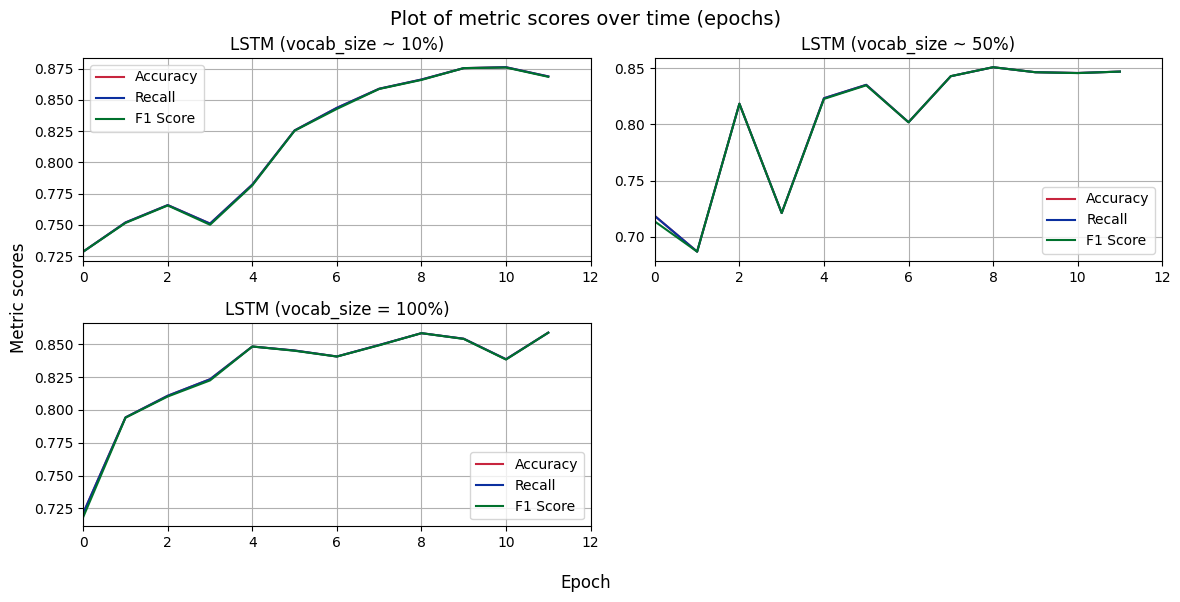

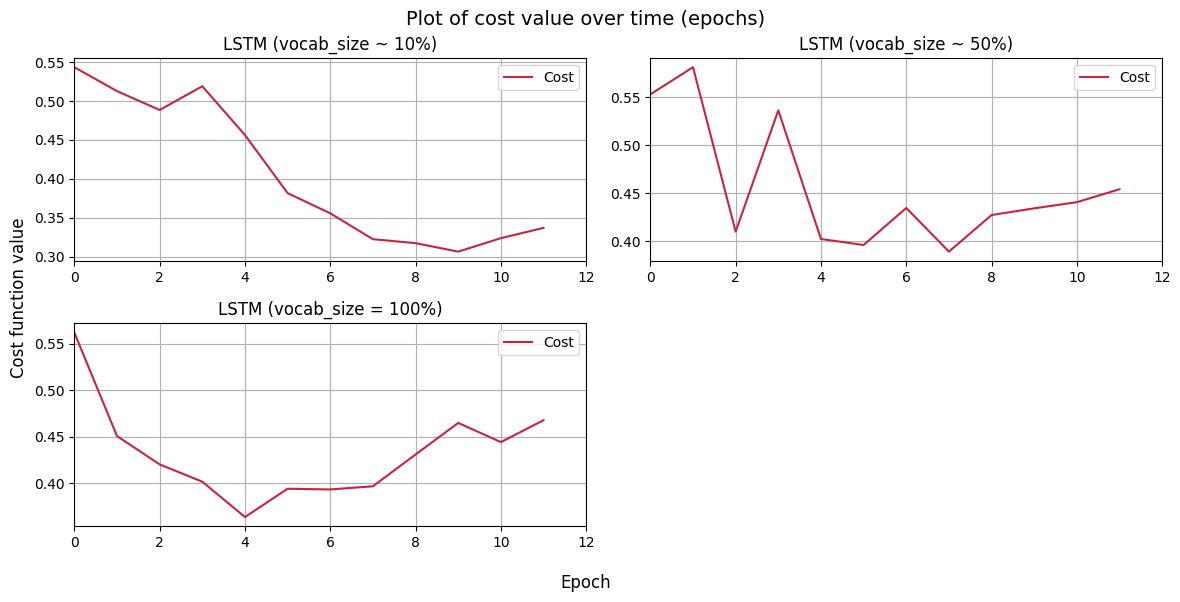

In [13]:
results_1 = filter_results(
    vocabulary_size=8000,
    rnn_type=RNNType.LSTM,
    hidden_dim=64,
    max_seq_len=None,
    embedding_dim=32,
    bidirectional=True
)
results_2 = filter_results(
    vocabulary_size=44000,
    rnn_type=RNNType.LSTM,
    hidden_dim=64,
    max_seq_len=None,
    embedding_dim=32,
    bidirectional=True
)
results_3 = filter_results(
    vocabulary_size=None,
    rnn_type=RNNType.LSTM,
    hidden_dim=64,
    max_seq_len=None,
    embedding_dim=32,
    bidirectional=True
)


results_with_titles = [
    (results_1.results, "LSTM (vocab_size ~ 10%)"),
    (results_2.results, "LSTM (vocab_size ~ 50%)"),
    (results_3.results, "LSTM (vocab_size = 100%)"),
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

### Recurrent layer type (RNN vs LSTM)

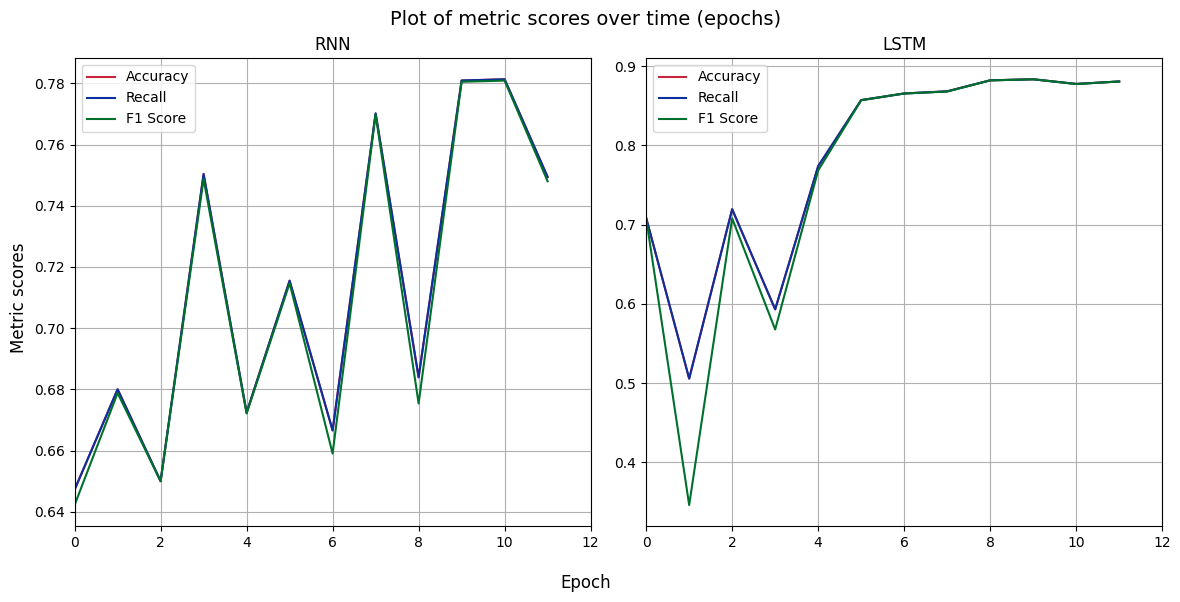

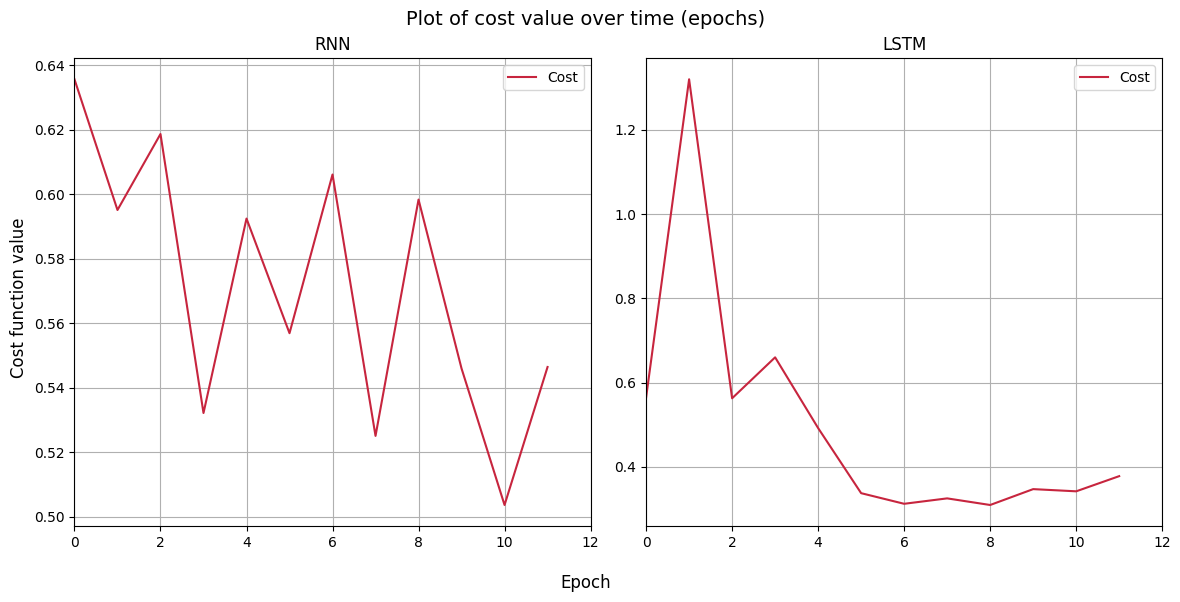

In [10]:
# param_grid_1 = {
#     "vocabulary_size": [8000, 44000, None],
#     "rnn_type": [RNNType.LSTM],
#     "hidden_dim": [64],
#     "max_seq_len": [None],
#     "embedding_dim": [32],
#     "bidirectional": [True]
# }
# param_grid_2 = {
#     "vocabulary_size": [10000],
#     "rnn_type": [RNNType.RNN, RNNType.LSTM],
#     "hidden_dim": [32, 64, 128],
#     "max_seq_len": [10, 20, None],
#     "embedding_dim": [16, 32, 64],
#     "bidirectional": [True, False]
# }

results_1 = filter_results(
    vocabulary_size=10000,
    rnn_type=RNNType.RNN,
    hidden_dim=128,
    max_seq_len=None,
    embedding_dim=64,
    bidirectional=True
)
results_2 = filter_results(
    vocabulary_size=10000,
    rnn_type=RNNType.LSTM,
    hidden_dim=128,
    max_seq_len=None,
    embedding_dim=64,
    bidirectional=True
)


results_with_titles = [
    (results_1.results, "RNN"),
    (results_2.results, "LSTM"),
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

#### Analysis
A first set of experiments was carried out to investigate the influence of the convolutional layers on the performance of the model (mainly the number of out channels). The graphs above show the results. The best metrics were achieved by the most complex model - with 2 convolutional layers (16 out channels and 32 out channels). After 5 epochs of training, all 3 metrics achieved a score higher than 0.91, which is an excellent result, much better than the best one from the previous lab (with the same dataset, but with a different model, without convolutional layers). In this case, the cost function was also the lowest, reaching ~0.24 in the end and showing no signs of overfitting.  

The other 2 configurations performed quite well, but they used only 1 convolutional layer (with 16 and 64 out channels). The model with a higher number of out channels in the convolutional layer performed slightly better - with a cost function at the same level as the one with 16 out channels, but with a more stable learning curve and higher overall metric values.  

We can clearly see how the number of out channels of the convolutional layer and a general architecture of this layer(s) affects the model performance. In our case, 16 out channels were sufficient for the model to achieve acceptable performance metrics, but using a layer with 4 times more out channels proved to be a better choice. However, this particular problem of image recognition and classification is quite complex, so the best choice is to use more than 1 convolutional layer. Unfortunately, no further experiments were carried out to explore this parameter influence further (due to computational limitations), but probably a configuration with 2 conv layers but more out channels or even with 3 conv layers would be the best choice for this exercise.

### Recurrent layer dimension

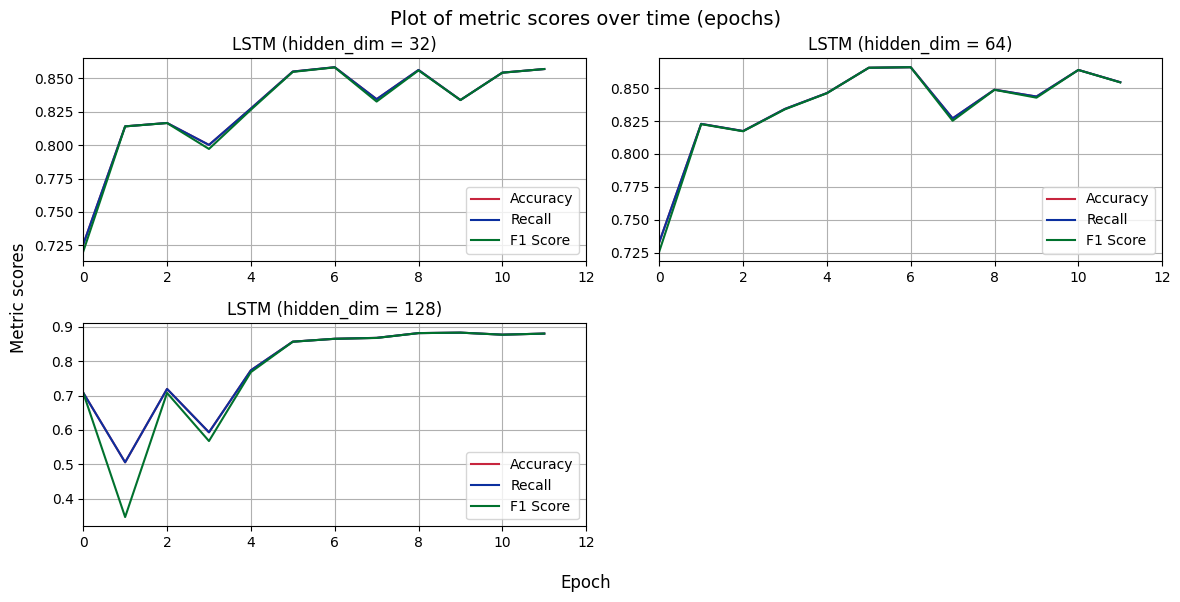

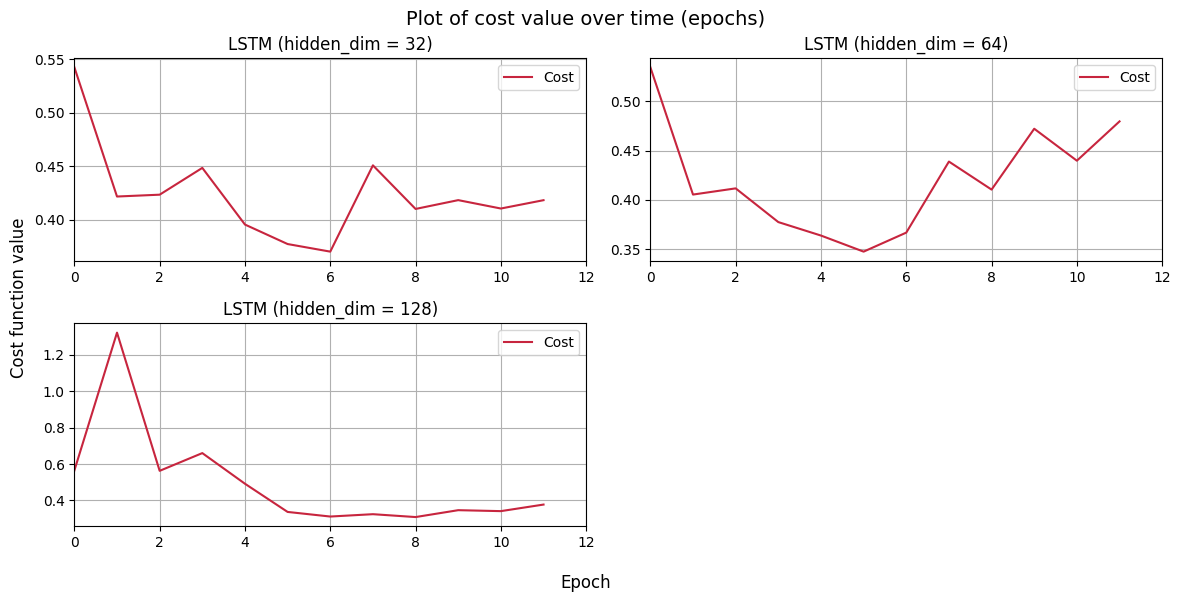

In [ ]:
results_1 = filter_results(
    vocabulary_size=10000,
    rnn_type=RNNType.LSTM,
    hidden_dim=32,
    max_seq_len=None,
    embedding_dim=64,
    bidirectional=True
)
results_2 = filter_results(
    vocabulary_size=10000,
    rnn_type=RNNType.LSTM,
    hidden_dim=64,
    max_seq_len=None,
    embedding_dim=64,
    bidirectional=True
)
results_3 = filter_results(
    vocabulary_size=10000,
    rnn_type=RNNType.LSTM,
    hidden_dim=128,
    max_seq_len=None,
    embedding_dim=64,
    bidirectional=True
)


results_with_titles = [
    (results_1.results, "LSTM (hidden_dim = 32)"),
    (results_2.results, "LSTM (hidden_dim = 64)"),
    (results_3.results, "LSTM (hidden_dim = 128)"),
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

#### Analysis
The second set of experiments was carried out to investigate the influence of the filter size (kernel) of the convolutional layer on the performance of the model. The plots above show the results. The best performance was achieved by the model with kernel size = 3, which proved to be the best compromise between overgeneralisation and overfitting. The model with kernel size = 5 achieved very high metric scores after 4 epochs (above 0.9), but showed signs of overfitting after the last epoch - due to the large kernel it generalised the data more and was not able to learn more. The model with kernel size = 2, on the other hand, learned at the slowest rate and probably needed more epochs to be well trained. However, it would have a higher probability of overfitting because it generalised too little.

### Pooling window size

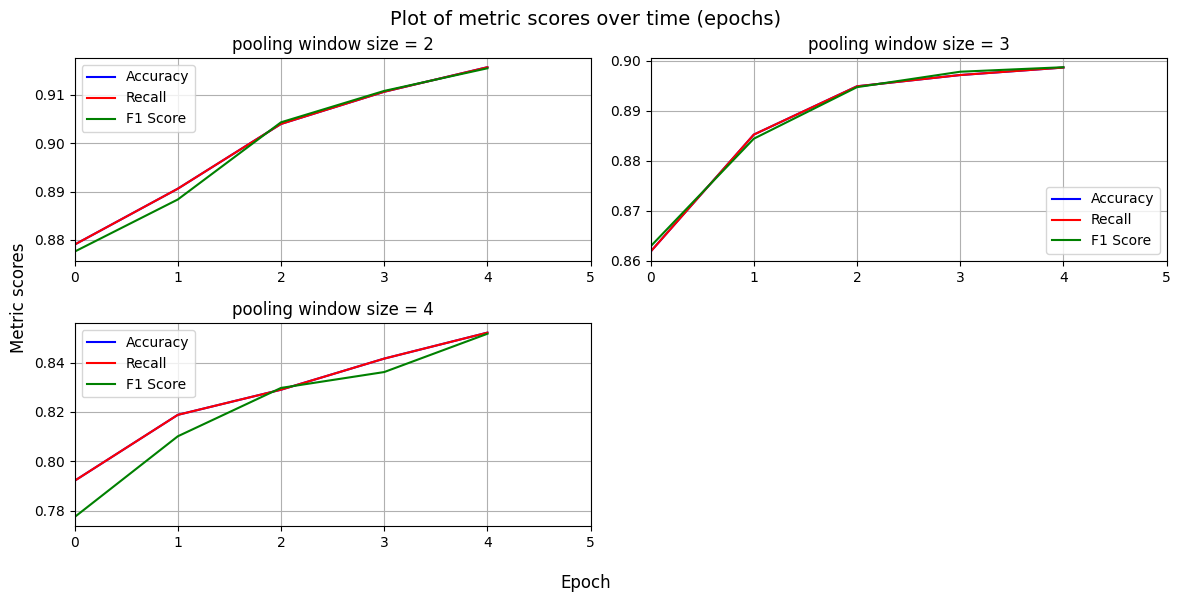

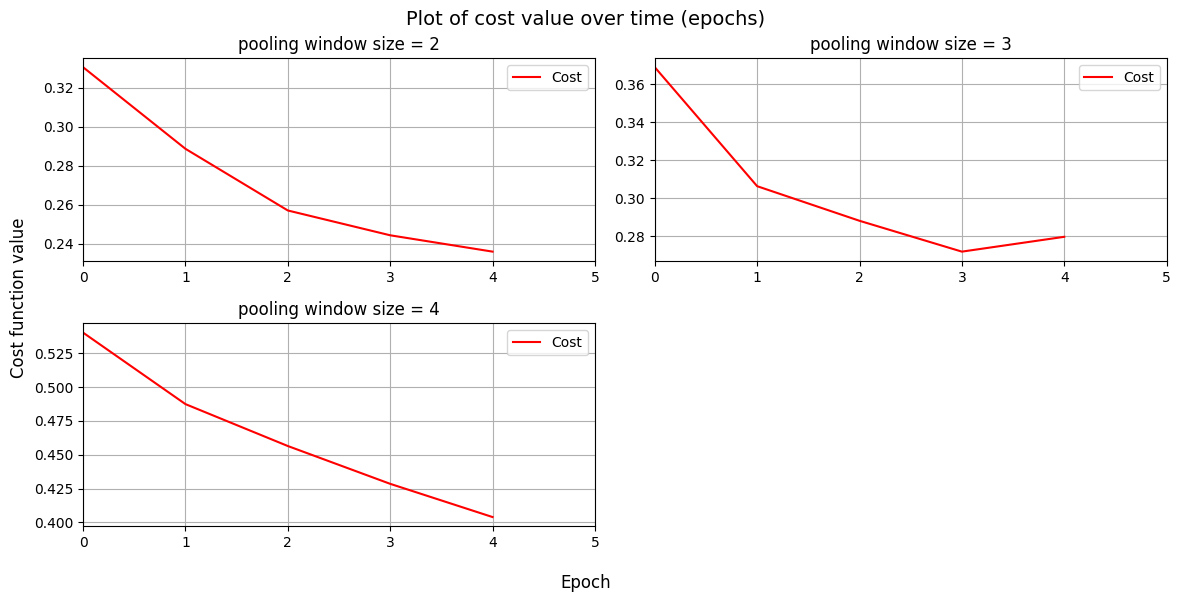

In [ ]:
results_1 = filter_results(
    conv_layer_dims=[(1, 16), (16, 32)],
    conv_kernel_size=3,
    pooling_window_size=2,
    train_noise_std=0.0,
    val_noise_std=0.0
)
results_2 = filter_results(
    conv_layer_dims=[(1, 16), (16, 32)],
    conv_kernel_size=3,
    pooling_window_size=3,
    train_noise_std=0.0,
    val_noise_std=0.0
)
results_3 = filter_results(
    conv_layer_dims=[(1, 16), (16, 32)],
    conv_kernel_size=3,
    pooling_window_size=4,
    train_noise_std=0.0,
    val_noise_std=0.0
)


results_with_titles = [
    (results_1.results, "pooling window size = 2"),
    (results_2.results, "pooling window size = 3"),
    (results_3.results, "pooling window size = 4")
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

#### Analysis
The third set of experiments was carried out to investigate the influence of the pooling window size of the Max Pooling Layer on the performance of the model. The plots above show the results. The best performance was achieved by the model with pooling window size = 2. The model with pooling window size = 3 performed worse but still acceptable - we can see that with this larger pooling window the model generalised the data more and after 4 epochs (reaching metric values close to 0.9 and cost function ~0.275) showed some symptoms of over-fitting, suggesting that this level of generalisation was too much for this particular task. The model with pooling window size = 4 performed the worst of all the models tested so far. The metric values reached only 0.85 and the cost function was finally higher than 0.4. This means that if the pooling window is too large, the model cannot be trained properly because too few data features are extracted and passed to the fully connected layers. That's why a pooling window size of 2 is the best choice in this context, because it performs some feature extraction, which is necessary, but does not yet overgeneralise the model.

### Data noise

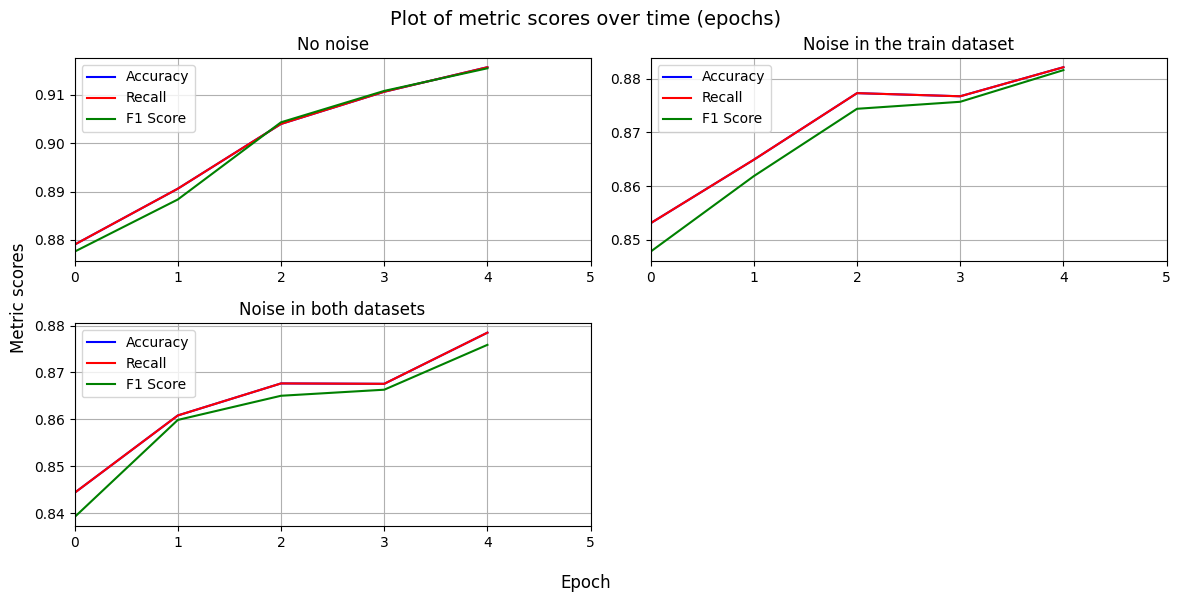

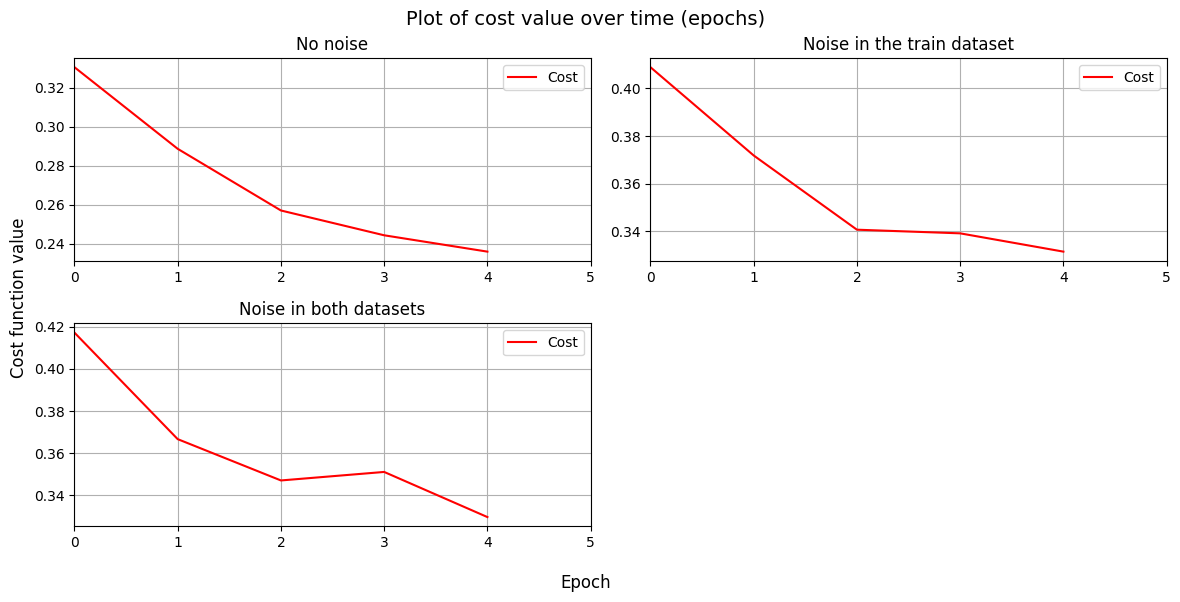

In [ ]:
results_1 = filter_results(
    conv_layer_dims=[(1, 16), (16, 32)],
    conv_kernel_size=3,
    pooling_window_size=2,
    train_noise_std=0.0,
    val_noise_std=0.0
)
results_2 = filter_results(
    conv_layer_dims=[(1, 16), (16, 32)],
    conv_kernel_size=3,
    pooling_window_size=2,
    train_noise_std=0.2,
    val_noise_std=0.0
)
results_3 = filter_results(
    conv_layer_dims=[(1, 16), (16, 32)],
    conv_kernel_size=3,
    pooling_window_size=2,
    train_noise_std=0.2,
    val_noise_std=0.2
)


results_with_titles = [
    (results_1.results, "No noise"),
    (results_2.results, "Noise in the train dataset"),
    (results_3.results, "Noise in both datasets")
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

#### Analysis
The no-noise scenario is the best performance achieved by the model (as shown in the previous comparisons). In the other two scenarios, the metrics start lower but also improve over time to reach values ~4% worse than the benchmark model. The difference is more significant when comparing the cost function values (~40% higher). These results highlight the importance of data quality. Techniques such as data augmentation, noise reduction or more robust model architectures may be necessary to improve performance in the presence of noisy data.